# Collaboration and Competition

---

This notebook runs John's solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.  It uses the Unity ML-Agents environment to train two cooperative agents to play a tennis-like game.

**Need more description here - refer to readme?**






...


This code depends upon a custom Unity environment provided by the Udacity staff that embodies the variation on tennis.  It will open a separate Unity window for visualizing the environment as the agents train or play.


## Define how we will use this notebook - JOHN FIX THIS!!!!

In the next cell, set the appropriate values of a couple control variables:
- **EXPLORE** determines whether the notebook does exploratory training or inference demonstration.
    - **True** runs a hyperparameter exploration loop to generate many training runs with a random search algorithm.  To use this well, you should study that cell and specify the ranges of hyperparameters to be explored.
    - **False** runs a few inference episodes of a pretrained model and opens a visualization window to watch it play.
- **config_name:** the name of a model configuration & run to be loaded from a checkpoint to begin the exercise.  
    - If EXPLORE = True, this is optional, and tells the training loop to start from this pre-trained model and continue refining it; if the value is _None_ then the training starts from a randomly initialized model.
    - If EXPLORE = False, then this must reflect the name of a legitimate config/run (e.g. "M37.01").
- **checkpoint_episode:** if a checkpoint is being used to start the exercise, then this number reflects what episode that checkpoint was captured from.  The checkpoint_name and checkpoint_episode together are required to completely identify the checkpoint file.


In [1]:
EXPLORE            = True
config_name        = None # Must be None if not using!
run_number         = 0
checkpoint_episode = 2

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from train import train
from maddpg import Maddpg

%matplotlib inline

initial_episode = checkpoint_episode
checkpoint_path = "checkpoint/{}/".format(config_name)
tag = "{}.{:02d}".format(config_name, run_number)

if EXPLORE:
    turn_off_graphics = True
    initial_episode = 0
    unity_train_mode = True
    if config_name != None:
        initial_episode = checkpoint_episode
else:
    turn_off_graphics = False
    unity_train_mode = False

# create a new Unity environment
# it needs to be done once, outside any loop, as closing an environment then restarting causes
# a Unity exception about the handle no longer being active.
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", seed=0, 
                       no_graphics=turn_off_graphics)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]                       
env_info = env.reset(train_mode=unity_train_mode)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Train the agents

The next cells will invoke the training program to create the agents.  All of the real code is in Python flat files in this project directory.

In [3]:
import numpy as np

class RandomSampler():
    
    def __init__(self, vars):
        """Accepts definition of the set of variables to be sampled.
            
            Params:
                vars (list of lists): each item is a list containing:
                                        item 0 - either 'discrete', 'continuous-int' or 'continuous-float'
                                        items 1-N depend on the value of item 0:
                                        if discrete, then these are the set of values to be chosen from
                                        if continuous then these are the min & max bounds of the range
        """
        
        self.vars = vars
        
        self.rng = np.random.default_rng()
    
    
    def sample(self):
        """Draws a random sample of all variables at its disposal.
        
            Returns a list of values in the order of definition.
        """

        rtn = []
        for v in self.vars:
            if v[0] == "discrete":
                choice = self.rng.integers(low=1, high=len(v), size=1)[0]
                rtn.append(v[choice])
                
            elif v[0] == "continuous-int":
                choice = self.rng.integers(low=v[1], high=v[2], size=1)[0]
                rtn.append(choice)
                
            elif v[0] == "continuous-float":
                choice = self.rng.random() * (v[2]-v[1]) + v[1]
                rtn.append(choice)
            
            else:
                print("///// RandomSampler error:  unknown type ", v[0])
            
        return rtn
                
vars = [["discrete", 88, 66, 11, 22, 33, 44, 99, 101, 77],
        ["discrete", 500], #1-item list
        ["continuous-int", 43, 44], #1-item range
        ["continuous-int", 0, 10],
        ["continuous-float", 0.0, 1.0],
        ["continuous-float", -3.3, 0.0],
        ["continuous-float", -1.0, 6.4],
       ]
rs = RandomSampler(vars)

for i in range(3):
    out = rs.sample()
    print("\n", i, "\n", out)



 0 
 [77, 500, 43, 9, 0.14425754404335134, -1.20140452099458, 4.833380067080445]

 1 
 [88, 500, 43, 1, 0.3681109899831394, -2.833202047132728, 5.824202120765459]

 2 
 [33, 500, 43, 7, 0.5089458819438436, -2.8003379809986066, 1.6482318212909801]


Ready to train M46 over 30 training sets for 10001 episodes each, with fixed params:
    Max episodes   =  10001
    Weight decay   =  1e-05
    Gamma          =  0.99
    LR anneal freq =  10000
    LR anneal mult =  1.0
    Buf prime size =  5000

///// Beginning training set  M46.00  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999453
      Noise scale      = 1.000
      LR actor         = 0.0006810
      LR critic        = 0.0002884
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00607
      Seed             =  44939
Priming the replay buffer........................!

146	Running avg/max: 0.000/0.000,  mem:   5297/     1 ( 0.0%), avg 604.1 eps/min   
* noise mult = 0.1
478	Running avg/max: 0.002/0.100,  mem:   6046/     3 ( 0.0%), avg 601.3 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7153/     3 ( 0.0%), avg 610.1 eps/min; 

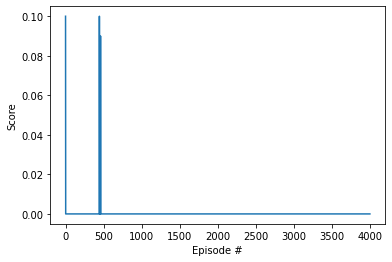

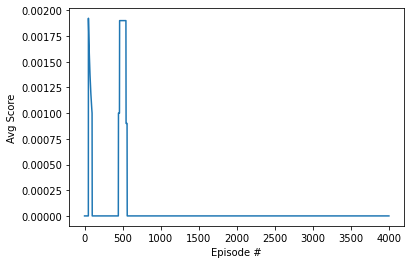


///// Beginning training set  M46.01  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999382
      Noise scale      = 0.020
      LR actor         = 0.0008283
      LR critic        = 0.0004442
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00153
      Seed             =  44939
Priming the replay buffer.........................!

126	Running avg/max: 0.000/0.000,  mem:   6853/     3 ( 0.0%), avg 598.0 eps/min   
* noise mult = 0.1
428	Running avg/max: 0.000/0.000,  mem:  11141/     3 ( 0.0%), avg 604.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19518/    11 ( 0.1%), avg 590.9 eps/min;  0.3 hr rem   
2000	Average score:   0.000,        mem:  33718/    11 ( 0.0%), avg 593.9 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  47918/    11 ( 0.0%), avg 604.0 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        m

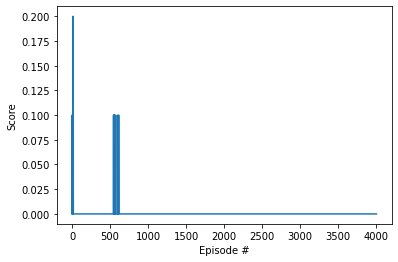

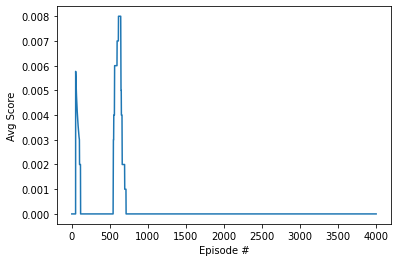


///// Beginning training set  M46.02  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999268
      Noise scale      = 1.000
      LR actor         = 0.0002101
      LR critic        = 0.0001040
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00186
      Seed             =  44939
Priming the replay buffer........................!

109	Running avg/max: 0.000/0.000,  mem:   5232/     1 ( 0.0%), avg 134.8 eps/min   
* noise mult = 0.1
364	Running avg/max: 0.000/0.000,  mem:   5793/     1 ( 0.0%), avg 134.5 eps/min   
* noise mult = 0.0005
1000	Average score:   0.001,        mem:   7140/     2 ( 0.0%), avg 133.8 eps/min;  1.1 hr rem   
2000	Average score:   0.074,        mem:  10056/   206 ( 2.0%), avg 117.6 eps/min;  1.1 hr rem   
2538	Running avg/max: 0.506/2.500,  mem:  15420/  1368 ( 8.9%), avg 75.9 eps/min    
Environment solved in 2538 episodes!	Average Score: 

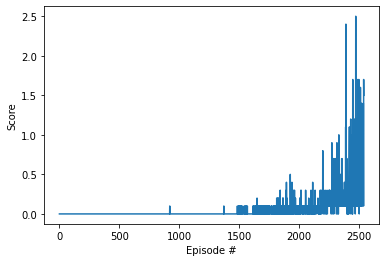

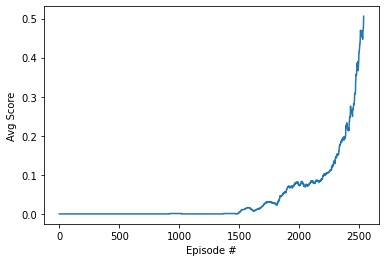


///// Beginning training set  M46.03  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999867
      Noise scale      = 1.000
      LR actor         = 0.0009880
      LR critic        = 0.0005738
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00693
      Seed             =  44939
Priming the replay buffer.........................!

591	Running avg/max: 0.010/0.100,  mem:   6299/    12 ( 0.2%), avg 118.5 eps/min   
* noise mult = 0.1
1000	Average score:   0.014,        mem:   7591/   110 ( 1.4%), avg 103.9 eps/min;  1.4 hr rem   
1604	Running avg/max: 0.039/0.100,  mem:   9538/   274 ( 2.9%), avg 96.6 eps/min    
* noise mult = 0.0005
2000	Average score:   0.038,        mem:  10949/   409 ( 3.7%), avg 91.6 eps/min;  1.5 hr rem   
3000	Average score:   0.026,        mem:  14760/   730 ( 4.9%), avg 84.9 eps/min;  1.4 hr rem   
4000	Average score:   0.036,        mem

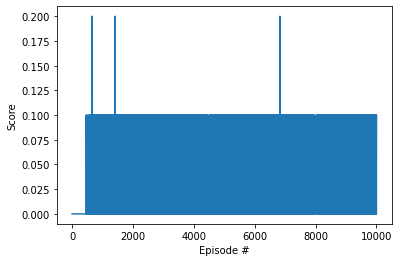

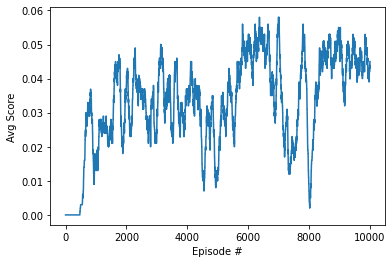


///// Beginning training set  M46.04  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999801
      Noise scale      = 1.000
      LR actor         = 0.0008859
      LR critic        = 0.0005803
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00219
      Seed             =  44939
Priming the replay buffer.........................!

403	Running avg/max: 0.000/0.000,  mem:  10773/     1 ( 0.0%), avg 526.3 eps/min   
* noise mult = 0.1
1000	Average score:   0.000,        mem:  19250/     1 ( 0.0%), avg 541.6 eps/min;  0.3 hr rem   
1340	Running avg/max: 0.000/0.000,  mem:  24078/     1 ( 0.0%), avg 538.7 eps/min   
* noise mult = 0.0005
2000	Average score:   0.000,        mem:  33450/     1 ( 0.0%), avg 538.7 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  47650/     1 ( 0.0%), avg 537.1 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        

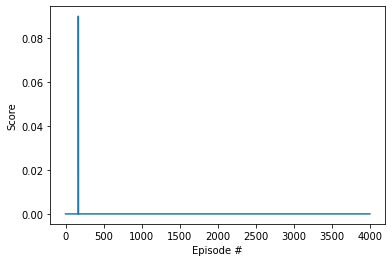

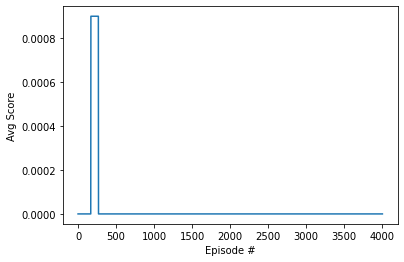


///// Beginning training set  M46.05  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999182
      Noise scale      = 1.000
      LR actor         = 0.0001601
      LR critic        = 0.0000935
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00353
      Seed             =  44939
Priming the replay buffer.........................!

92	Running avg/max: 0.003/0.100,  mem:   5220/     3 ( 0.1%), avg 517.8 eps/min   
* noise mult = 0.1
320	Running avg/max: 0.000/0.000,  mem:   5715/     3 ( 0.1%), avg 524.0 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7174/     3 ( 0.0%), avg 525.8 eps/min;  0.3 hr rem   
2000	Average score:   0.000,        mem:   9278/     3 ( 0.0%), avg 539.8 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  11449/     3 ( 0.0%), avg 539.6 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        me

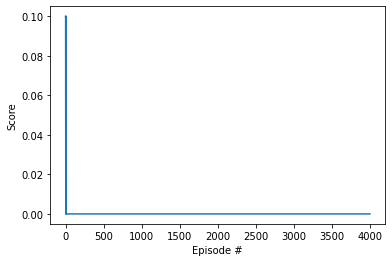

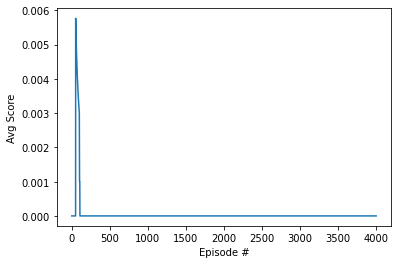


///// Beginning training set  M46.06  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999896
      Noise scale      = 0.100
      LR actor         = 0.0001265
      LR critic        = 0.0001043
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00448
      Seed             =  44939
Priming the replay buffer.........................!

776	Running avg/max: 0.000/0.000,  mem:   6668/     0 ( 0.0%), avg 120.9 eps/min   
* noise mult = 0.1
1000	Average score:   0.025,        mem:   7268/    34 ( 0.5%), avg 115.3 eps/min;  1.3 hr rem   
1656	Running avg/max: 0.163/1.600,  mem:  11056/   696 ( 6.3%), avg 79.9 eps/min    
* noise mult = 0.0005
2000	Average score:   0.289,        mem:  15446/  1694 (11.0%), avg 59.0 eps/min;  2.3 hr rem   
2062	Running avg/max: 0.501/3.100,  mem:  17022/  2085 (12.2%), avg 53.6 eps/min   
Environment solved in 2062 episodes!	Average Score: 

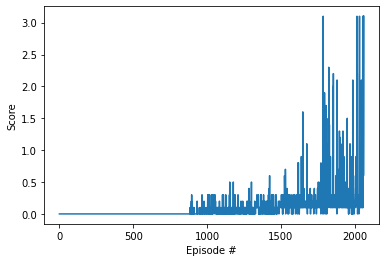

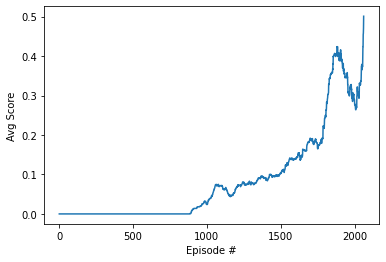


///// Beginning training set  M46.07  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999016
      Noise scale      = 0.020
      LR actor         = 0.0007125
      LR critic        = 0.0006067
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00494
      Seed             =  44939
Priming the replay buffer.........................!

81	Running avg/max: 0.000/0.000,  mem:   6163/     0 ( 0.0%), avg 125.6 eps/min   
* noise mult = 0.1
271	Running avg/max: 0.000/0.000,  mem:   8861/     0 ( 0.0%), avg 124.5 eps/min   
* noise mult = 0.0005
1000	Average score:   0.003,        mem:  19330/     6 ( 0.0%), avg 123.7 eps/min;  1.2 hr rem   
2000	Average score:   0.033,        mem:  37312/   185 ( 0.5%), avg 110.4 eps/min;  1.2 hr rem   
3000	Average score:   0.026,        mem:  62433/   541 ( 0.9%), avg 93.7 eps/min;  1.2 hr rem   
4000	Average score:   0.046,        mem:

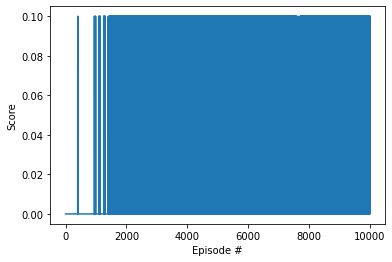

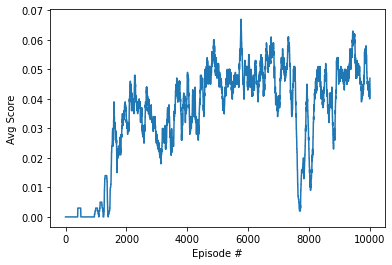


///// Beginning training set  M46.08  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999123
      Noise scale      = 1.000
      LR actor         = 0.0004246
      LR critic        = 0.0003338
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00518
      Seed             =  44939
Priming the replay buffer.........................!

90	Running avg/max: 0.000/0.000,  mem:   6308/     0 ( 0.0%), avg 586.1 eps/min   
* noise mult = 0.1
303	Running avg/max: 0.000/0.000,  mem:   9332/     0 ( 0.0%), avg 603.3 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19230/     0 ( 0.0%), avg 611.5 eps/min;  0.2 hr rem   
2000	Average score:   0.000,        mem:  33434/     0 ( 0.0%), avg 618.7 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  47678/     2 ( 0.0%), avg 622.3 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        me

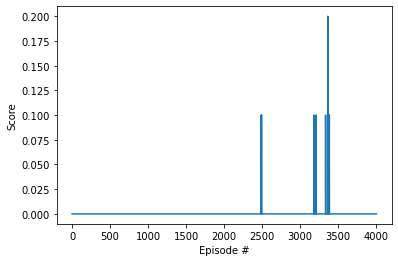

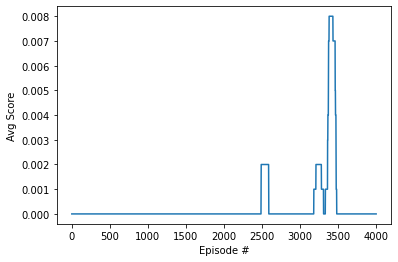


///// Beginning training set  M46.09  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999712
      Noise scale      = 0.020
      LR actor         = 0.0009759
      LR critic        = 0.0005883
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00779
      Seed             =  44939
Priming the replay buffer.........................!

280	Running avg/max: 0.000/0.000,  mem:   8996/     1 ( 0.0%), avg 610.8 eps/min   
* noise mult = 0.1
927	Running avg/max: 0.000/0.000,  mem:  18183/     1 ( 0.0%), avg 621.4 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19220/     1 ( 0.0%), avg 621.8 eps/min;  0.2 hr rem   
2000	Average score:   0.000,        mem:  33420/     1 ( 0.0%), avg 625.3 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  47620/     1 ( 0.0%), avg 629.9 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        m

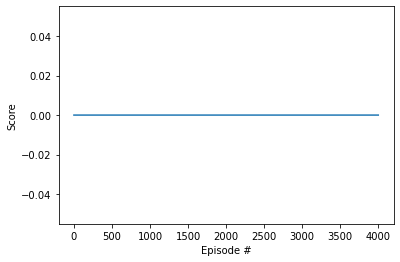

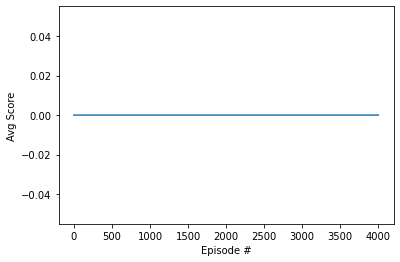


///// Beginning training set  M46.10  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999840
      Noise scale      = 0.100
      LR actor         = 0.0003695
      LR critic        = 0.0001156
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00578
      Seed             =  44939
Priming the replay buffer.........................!

503	Running avg/max: 0.000/0.000,  mem:   6092/     1 ( 0.0%), avg 529.6 eps/min   
* noise mult = 0.1
1000	Average score:   0.000,        mem:   7177/     2 ( 0.0%), avg 522.9 eps/min;  0.3 hr rem   
1665	Running avg/max: 0.000/0.000,  mem:   8573/     2 ( 0.0%), avg 523.9 eps/min   
* noise mult = 0.0005
2000	Average score:   0.000,        mem:   9258/     2 ( 0.0%), avg 522.0 eps/min;  0.3 hr rem   
3000	Average score:   0.000,        mem:  11446/     6 ( 0.1%), avg 526.4 eps/min;  0.2 hr rem   
4000	Average score:   0.028,        

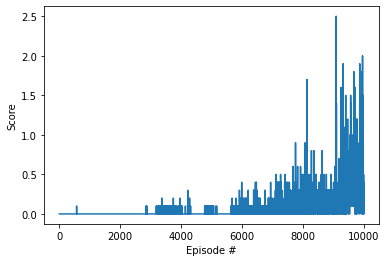

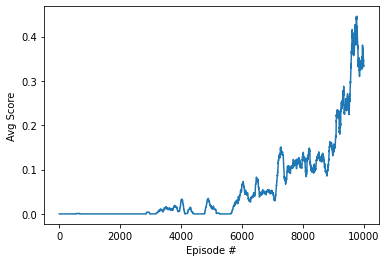


///// Beginning training set  M46.11  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999268
      Noise scale      = 0.100
      LR actor         = 0.0008305
      LR critic        = 0.0007417
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00969
      Seed             =  44939
Priming the replay buffer.........................!

109	Running avg/max: 0.000/0.000,  mem:   5248/     0 ( 0.0%), avg 565.1 eps/min   
* noise mult = 0.1
363	Running avg/max: 0.000/0.000,  mem:   5789/     0 ( 0.0%), avg 557.0 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7145/     0 ( 0.0%), avg 555.2 eps/min;  0.3 hr rem   
2000	Average score:   0.000,        mem:   9286/     0 ( 0.0%), avg 551.7 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  11436/     0 ( 0.0%), avg 542.6 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        m

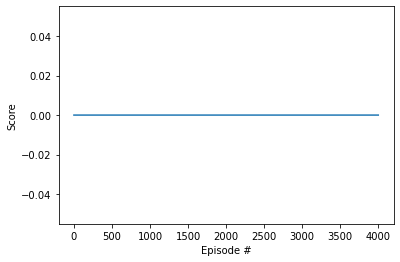

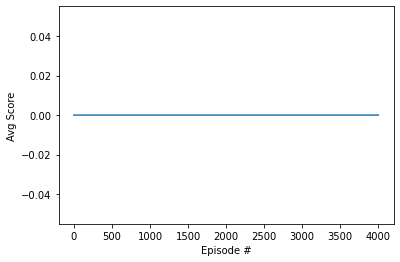


///// Beginning training set  M46.12  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999861
      Noise scale      = 1.000
      LR actor         = 0.0001147
      LR critic        = 0.0000989
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00167
      Seed             =  44939
Priming the replay buffer.........................!

576	Running avg/max: 0.000/0.000,  mem:  13300/     4 ( 0.0%), avg 544.7 eps/min   
* noise mult = 0.1
1000	Average score:   0.000,        mem:  19321/     4 ( 0.0%), avg 546.5 eps/min;  0.3 hr rem   
1923	Running avg/max: 0.000/0.000,  mem:  32427/     4 ( 0.0%), avg 549.4 eps/min   
* noise mult = 0.0005
2000	Average score:   0.000,        mem:  33521/     4 ( 0.0%), avg 549.7 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  47724/     4 ( 0.0%), avg 551.6 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        

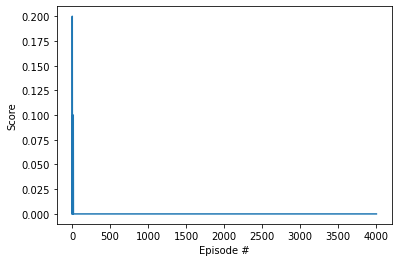

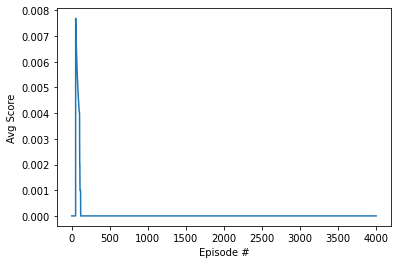


///// Beginning training set  M46.13  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999357
      Noise scale      = 0.100
      LR actor         = 0.0001518
      LR critic        = 0.0000613
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00948
      Seed             =  44939
Priming the replay buffer.........................!

122	Running avg/max: 0.002/0.200,  mem:   6791/     3 ( 0.0%), avg 117.6 eps/min   
* noise mult = 0.1
412	Running avg/max: 0.000/0.000,  mem:  10909/     3 ( 0.0%), avg 121.3 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19259/     3 ( 0.0%), avg 121.8 eps/min;  1.2 hr rem   
2000	Average score:   0.026,        mem:  35815/   138 ( 0.4%), avg 112.8 eps/min;  1.2 hr rem   
3000	Average score:   0.284,        mem:  76639/  1600 ( 2.1%), avg 72.7 eps/min;  1.6 hr rem   
3227	Running avg/max: 0.500/3.100,  mem

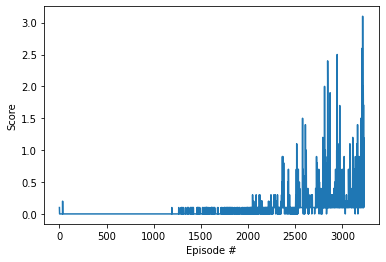

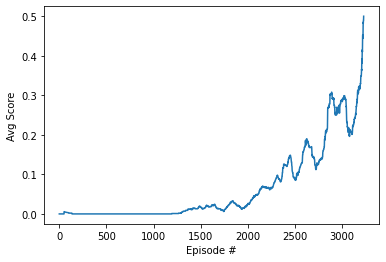


///// Beginning training set  M46.14  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999783
      Noise scale      = 0.100
      LR actor         = 0.0005131
      LR critic        = 0.0004697
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00951
      Seed             =  44939
Priming the replay buffer.........................!

370	Running avg/max: 0.001/0.090,  mem:  10299/     2 ( 0.0%), avg 307.3 eps/min   
* noise mult = 0.1
1000	Average score:   0.000,        mem:  19245/     2 ( 0.0%), avg 308.0 eps/min;  0.5 hr rem   
1230	Running avg/max: 0.000/0.000,  mem:  22511/     2 ( 0.0%), avg 306.1 eps/min   
* noise mult = 0.0005
2000	Average score:   0.000,        mem:  33445/     2 ( 0.0%), avg 306.8 eps/min;  0.4 hr rem   
3000	Average score:   0.026,        mem:  49574/    91 ( 0.2%), avg 294.3 eps/min;  0.4 hr rem   
4000	Average score:   0.019,        m

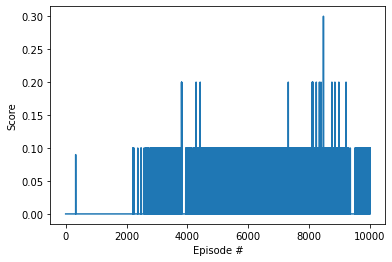

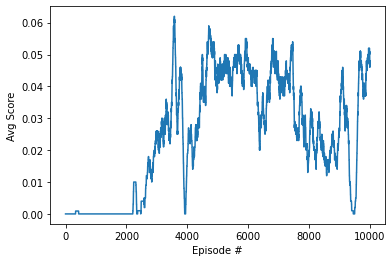


///// Beginning training set  M46.15  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999044
      Noise scale      = 1.000
      LR actor         = 0.0003813
      LR critic        = 0.0001554
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00235
      Seed             =  44939
Priming the replay buffer.........................!

82	Running avg/max: 0.001/0.100,  mem:   6195/     1 ( 0.0%), avg 302.3 eps/min   
* noise mult = 0.1
276	Running avg/max: 0.000/0.000,  mem:   8975/     1 ( 0.0%), avg 303.3 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19256/     1 ( 0.0%), avg 302.2 eps/min;  0.5 hr rem   
2000	Average score:   0.000,        mem:  33456/     1 ( 0.0%), avg 297.3 eps/min;  0.4 hr rem   
3000	Average score:   0.000,        mem:  47656/     1 ( 0.0%), avg 297.9 eps/min;  0.4 hr rem   
4000	Average score:   0.000,        mem

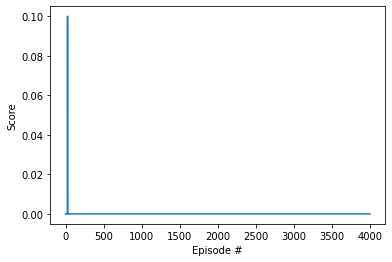

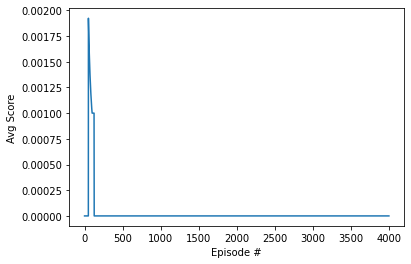


///// Beginning training set  M46.16  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999628
      Noise scale      = 0.100
      LR actor         = 0.0007955
      LR critic        = 0.0006559
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00417
      Seed             =  44939
Priming the replay buffer.........................!

216	Running avg/max: 0.000/0.000,  mem:   5457/     1 ( 0.0%), avg 124.9 eps/min   
* noise mult = 0.1
714	Running avg/max: 0.000/0.000,  mem:   6553/     3 ( 0.0%), avg 126.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.006,        mem:   7220/    20 ( 0.3%), avg 123.3 eps/min;  1.2 hr rem   
2000	Average score:   0.053,        mem:  11247/   488 ( 4.3%), avg 95.4 eps/min;  1.4 hr rem   
3000	Average score:   0.085,        mem:  16658/  1368 ( 8.2%), avg 80.3 eps/min;  1.5 hr rem   
4000	Average score:   0.118,        mem:

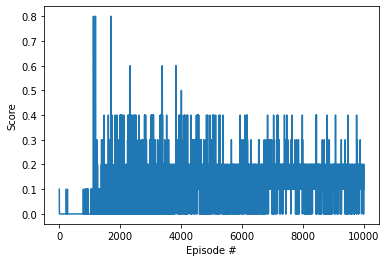

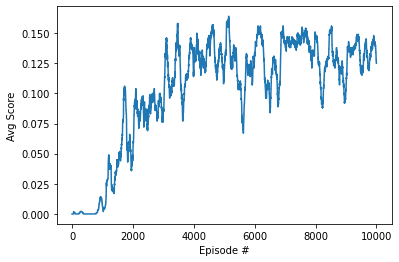


///// Beginning training set  M46.17  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999601
      Noise scale      = 0.020
      LR actor         = 0.0002027
      LR critic        = 0.0001072
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00881
      Seed             =  44939
Priming the replay buffer.........................!

199	Running avg/max: 0.000/0.000,  mem:   7879/     3 ( 0.0%), avg 676.6 eps/min   
* noise mult = 0.1
666	Running avg/max: 0.000/0.000,  mem:  14524/     3 ( 0.0%), avg 633.0 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19267/     3 ( 0.0%), avg 640.1 eps/min;  0.2 hr rem   
2000	Average score:   0.000,        mem:  33467/     3 ( 0.0%), avg 629.5 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  47730/     3 ( 0.0%), avg 627.1 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        m

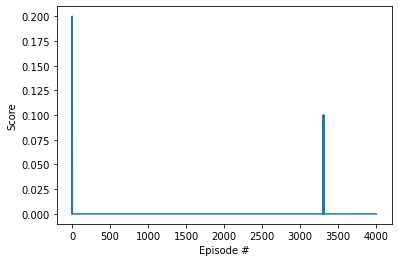

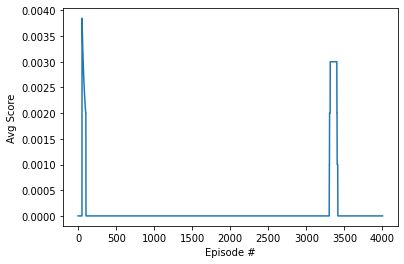


///// Beginning training set  M46.18  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999811
      Noise scale      = 1.000
      LR actor         = 0.0009947
      LR critic        = 0.0006630
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00438
      Seed             =  44939
Priming the replay buffer........................!

428	Running avg/max: 0.000/0.000,  mem:   5916/     0 ( 0.0%), avg 649.4 eps/min   
* noise mult = 0.1
1000	Average score:   0.000,        mem:   7129/     0 ( 0.0%), avg 650.6 eps/min;  0.2 hr rem   
1417	Running avg/max: 0.000/0.000,  mem:   8040/     0 ( 0.0%), avg 646.1 eps/min   
* noise mult = 0.0005
2000	Average score:   0.000,        mem:   9287/     1 ( 0.0%), avg 645.3 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  11395/     2 ( 0.0%), avg 636.1 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        m

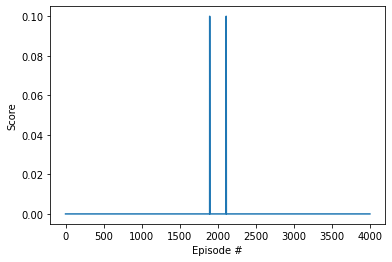

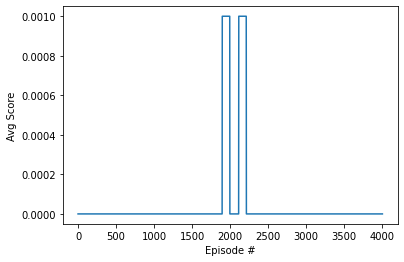


///// Beginning training set  M46.19  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999027
      Noise scale      = 1.000
      LR actor         = 0.0008809
      LR critic        = 0.0001485
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00221
      Seed             =  44939
Priming the replay buffer.........................!

82	Running avg/max: 0.001/0.100,  mem:   5179/     1 ( 0.0%), avg 135.1 eps/min   
* noise mult = 0.1
267	Running avg/max: 0.004/0.200,  mem:   5591/     5 ( 0.1%), avg 131.8 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7197/    18 ( 0.3%), avg 129.1 eps/min;  1.2 hr rem   
2000	Average score:   0.024,        mem:   9509/    62 ( 0.7%), avg 125.4 eps/min;  1.1 hr rem   
3000	Average score:   0.279,        mem:  18239/  1876 (10.3%), avg 70.9 eps/min;  1.6 hr rem   
3313	Running avg/max: 0.516/3.100,  mem:

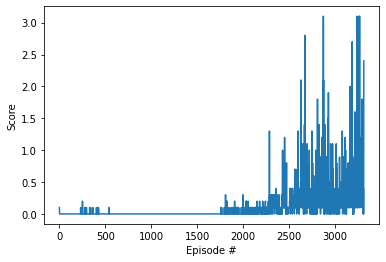

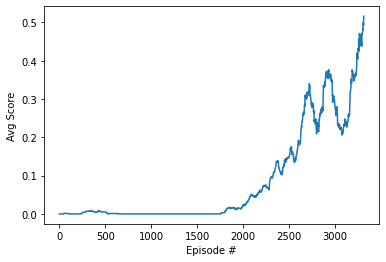


///// Beginning training set  M46.20  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999231
      Noise scale      = 0.020
      LR actor         = 0.0001281
      LR critic        = 0.0001176
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00869
      Seed             =  44939
Priming the replay buffer.........................!

104	Running avg/max: 0.000/0.000,  mem:   5215/     0 ( 0.0%), avg 121.8 eps/min   
* noise mult = 0.1
346	Running avg/max: 0.000/0.000,  mem:   5773/     0 ( 0.0%), avg 124.4 eps/min   
* noise mult = 0.0005
1000	Average score:   0.044,        mem:   7454/    74 ( 1.0%), avg 113.6 eps/min;  1.3 hr rem   
1983	Running avg/max: 0.512/3.200,  mem:  13639/  1204 ( 8.8%), avg 70.4 eps/min    
Environment solved in 1983 episodes!	Average Score: 0.51

Avg/max time steps/episode = 4.6/583


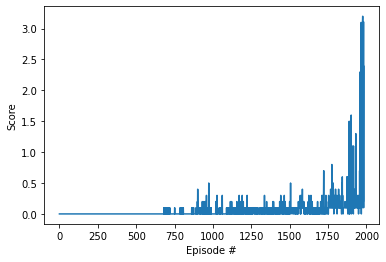

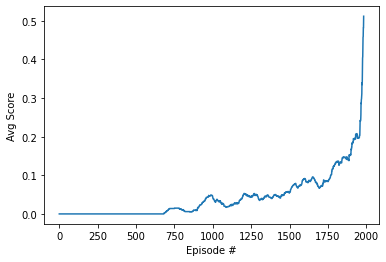


///// Beginning training set  M46.21  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999677
      Noise scale      = 0.100
      LR actor         = 0.0001426
      LR critic        = 0.0000630
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00834
      Seed             =  44939
Priming the replay buffer.........................!

248	Running avg/max: 0.000/0.000,  mem:   8558/     1 ( 0.0%), avg 126.8 eps/min   
* noise mult = 0.1
825	Running avg/max: 0.000/0.000,  mem:  16758/     1 ( 0.0%), avg 124.7 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19243/     1 ( 0.0%), avg 124.7 eps/min;  1.2 hr rem   
2000	Average score:   0.037,        mem:  37055/   193 ( 0.5%), avg 111.2 eps/min;  1.2 hr rem   
2764	Running avg/max: 0.513/3.100,  mem:  70113/  1396 ( 2.0%), avg 75.2 eps/min    
Environment solved in 2764 episodes!	Average Score:

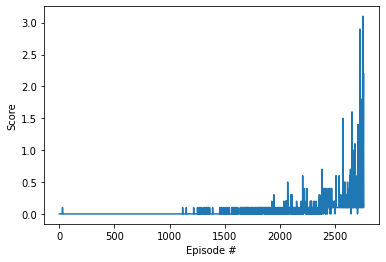

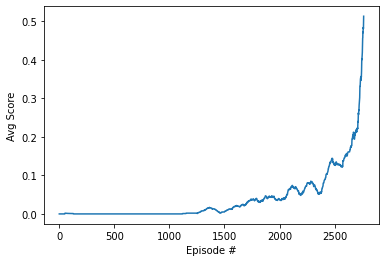


///// Beginning training set  M46.22  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999164
      Noise scale      = 0.020
      LR actor         = 0.0005378
      LR critic        = 0.0002521
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00225
      Seed             =  44939
Priming the replay buffer.........................!

95	Running avg/max: 0.000/0.000,  mem:   5209/     1 ( 0.0%), avg 314.5 eps/min   
* noise mult = 0.1
318	Running avg/max: 0.000/0.000,  mem:   5689/     1 ( 0.0%), avg 315.7 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7153/     1 ( 0.0%), avg 309.4 eps/min;  0.5 hr rem   
2000	Average score:   0.000,        mem:   9269/     2 ( 0.0%), avg 309.1 eps/min;  0.4 hr rem   
3000	Average score:   0.000,        mem:  11426/     3 ( 0.0%), avg 309.6 eps/min;  0.4 hr rem   
4000	Average score:   0.000,        mem

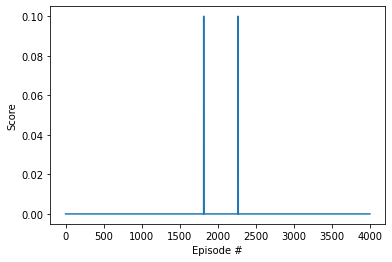

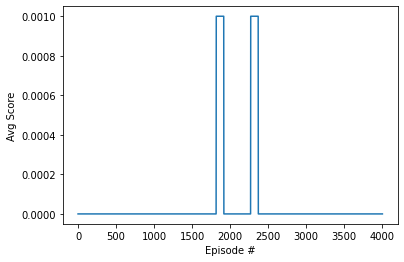


///// Beginning training set  M46.23  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999146
      Noise scale      = 1.000
      LR actor         = 0.0005111
      LR critic        = 0.0002869
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00886
      Seed             =  44939
Priming the replay buffer.........................!

94	Running avg/max: 0.000/0.000,  mem:   5186/     0 ( 0.0%), avg 120.8 eps/min   
* noise mult = 0.1
312	Running avg/max: 0.000/0.000,  mem:   5657/     0 ( 0.0%), avg 124.6 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7134/     0 ( 0.0%), avg 124.1 eps/min;  1.2 hr rem   
2000	Average score:   0.000,        mem:   9266/     0 ( 0.0%), avg 122.6 eps/min;  1.1 hr rem   
3000	Average score:   0.000,        mem:  11379/     0 ( 0.0%), avg 122.0 eps/min;  1.0 hr rem   
4000	Average score:   0.000,        mem

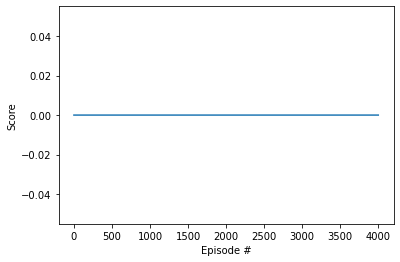

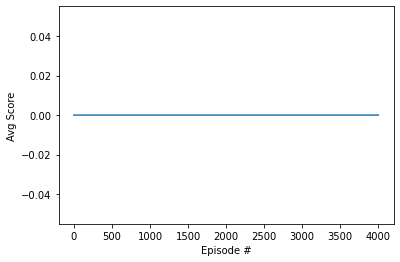


///// Beginning training set  M46.24  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999151
      Noise scale      = 0.020
      LR actor         = 0.0007921
      LR critic        = 0.0004689
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00273
      Seed             =  44939
Priming the replay buffer.........................!

94	Running avg/max: 0.000/0.000,  mem:   6350/     0 ( 0.0%), avg 548.8 eps/min   
* noise mult = 0.1
314	Running avg/max: 0.000/0.000,  mem:   9474/     0 ( 0.0%), avg 544.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19215/     0 ( 0.0%), avg 547.9 eps/min;  0.3 hr rem   
2000	Average score:   0.007,        mem:  33701/    14 ( 0.0%), avg 548.3 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  48080/    25 ( 0.1%), avg 551.7 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        me

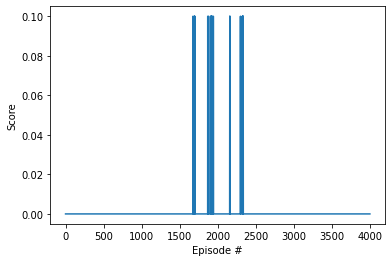

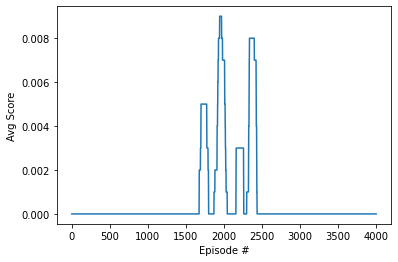


///// Beginning training set  M46.25  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999698
      Noise scale      = 1.000
      LR actor         = 0.0001731
      LR critic        = 0.0000210
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00175
      Seed             =  44939
Priming the replay buffer.........................!

267	Running avg/max: 0.000/0.000,  mem:   5590/     0 ( 0.0%), avg 316.4 eps/min   
* noise mult = 0.1
885	Running avg/max: 0.000/0.000,  mem:   6932/     0 ( 0.0%), avg 315.4 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:   7167/     0 ( 0.0%), avg 314.1 eps/min;  0.5 hr rem   
2000	Average score:   0.000,        mem:   9295/     0 ( 0.0%), avg 311.9 eps/min;  0.4 hr rem   
3000	Average score:   0.000,        mem:  11406/     0 ( 0.0%), avg 312.1 eps/min;  0.4 hr rem   
4000	Average score:   0.000,        me

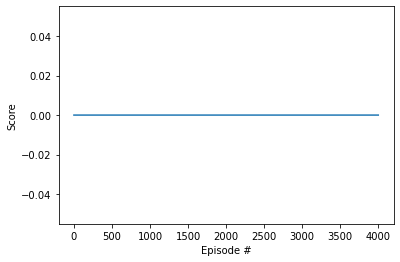

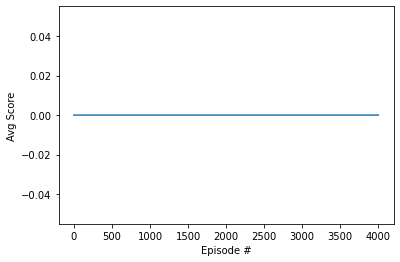


///// Beginning training set  M46.26  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999113
      Noise scale      = 0.100
      LR actor         = 0.0001501
      LR critic        = 0.0000908
      Learning every      8  time steps
      Learn iterations =  1
      Tau              = 0.00129
      Seed             =  44939
Priming the replay buffer.........................!

90	Running avg/max: 0.000/0.000,  mem:   6294/     0 ( 0.0%), avg 309.2 eps/min   
* noise mult = 0.1
300	Running avg/max: 0.000/0.000,  mem:   9276/     0 ( 0.0%), avg 306.2 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19216/     0 ( 0.0%), avg 305.6 eps/min;  0.5 hr rem   
2000	Average score:   0.000,        mem:  33416/     0 ( 0.0%), avg 307.7 eps/min;  0.4 hr rem   
3000	Average score:   0.000,        mem:  47616/     0 ( 0.0%), avg 311.0 eps/min;  0.4 hr rem   
4000	Average score:   0.000,        mem

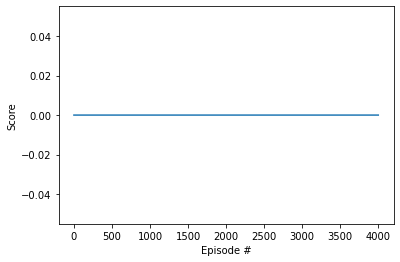

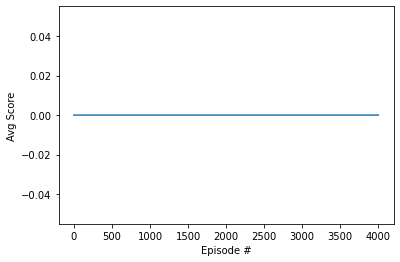


///// Beginning training set  M46.27  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.1500
      Noise decay      = 0.999860
      Noise scale      = 1.000
      LR actor         = 0.0008323
      LR critic        = 0.0005928
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00790
      Seed             =  44939
Priming the replay buffer.........................!

576	Running avg/max: 0.000/0.000,  mem:   6242/     1 ( 0.0%), avg 124.5 eps/min   
* noise mult = 0.1
1000	Average score:   0.048,        mem:   7403/    78 ( 1.1%), avg 113.6 eps/min;  1.3 hr rem   
1531	Running avg/max: 0.042/0.100,  mem:   9344/   305 ( 3.3%), avg 100.5 eps/min   
* noise mult = 0.0005
2000	Average score:   0.054,        mem:  11164/   543 ( 4.9%), avg 94.3 eps/min;  1.4 hr rem   
3000	Average score:   0.050,        mem:  14794/   986 ( 6.7%), avg 89.7 eps/min;  1.3 hr rem   
4000	Average score:   0.040,        mem

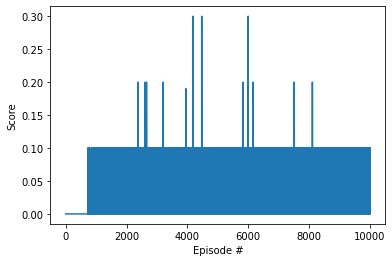

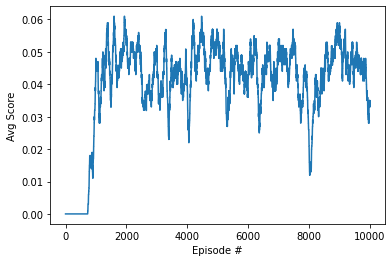


///// Beginning training set  M46.28  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999378
      Noise scale      = 1.000
      LR actor         = 0.0006102
      LR critic        = 0.0005121
      Learning every      20  time steps
      Learn iterations =  1
      Tau              = 0.00959
      Seed             =  44939
Priming the replay buffer.........................!

128	Running avg/max: 0.000/0.000,  mem:   6848/     1 ( 0.0%), avg 556.3 eps/min   
* noise mult = 0.1
428	Running avg/max: 0.000/0.000,  mem:  11108/     1 ( 0.0%), avg 556.9 eps/min   
* noise mult = 0.0005
1000	Average score:   0.000,        mem:  19231/     1 ( 0.0%), avg 569.1 eps/min;  0.3 hr rem   
2000	Average score:   0.000,        mem:  33526/     3 ( 0.0%), avg 572.2 eps/min;  0.2 hr rem   
3000	Average score:   0.000,        mem:  47726/     3 ( 0.0%), avg 564.9 eps/min;  0.2 hr rem   
4000	Average score:   0.000,        m

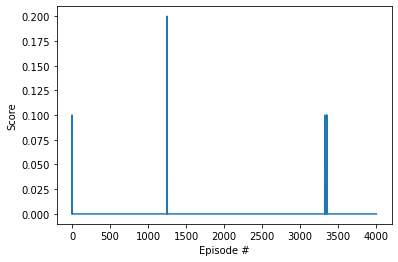

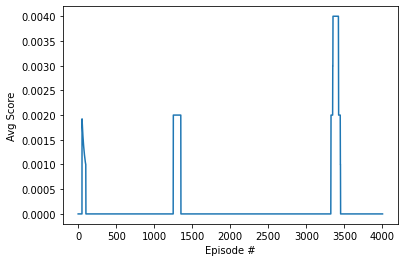


///// Beginning training set  M46.29  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 1.0000
      Noise decay      = 0.999757
      Noise scale      = 0.100
      LR actor         = 0.0001378
      LR critic        = 0.0001277
      Learning every      2  time steps
      Learn iterations =  1
      Tau              = 0.00166
      Seed             =  44939
Priming the replay buffer.........................!

332	Running avg/max: 0.000/0.000,  mem:   9731/     0 ( 0.0%), avg 124.1 eps/min   
* noise mult = 0.1
1000	Average score:   0.000,        mem:  19216/     0 ( 0.0%), avg 126.1 eps/min;  1.2 hr rem   
1100	Running avg/max: 0.000/0.000,  mem:  20636/     0 ( 0.0%), avg 126.1 eps/min   
* noise mult = 0.0005
2000	Average score:   0.003,        mem:  33733/    14 ( 0.0%), avg 124.7 eps/min;  1.1 hr rem   
3000	Average score:   0.024,        mem:  50173/   114 ( 0.2%), avg 119.6 eps/min;  1.0 hr rem   
4000	Average score:   0.052,        m

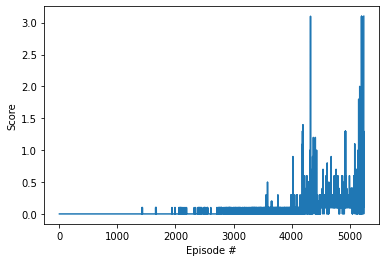

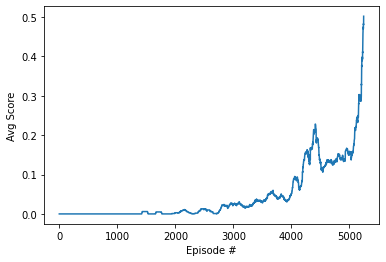



DONE!


In [4]:
# This cell will explore several combinations of hyperparams by training all of them
# Use a random search for the hyperparams

TIME_STEPS         = 600
SAVE_ANALYSIS      = False
MODEL_DISPLAY_STEP = 0 #200k is approx 10k episodes at bad_step_prob = 0.01

if EXPLORE:
    
    # fixed for the session:
    RUN_PREFIX        = "M46" #next 46
    EPISODES          = 10001
    NUM_RUNS          = 30
    BUFFER_PRIME_SIZE = 5000
    WEIGHT_DECAY      = 1.0e-5 #was 1.0e-5
    GAMMA             = 0.99
    LR_ANNEAL_FREQ    = 10000 #episodes
    LR_ANNEAL_MULT    = 1.0
    SEED              = 44939 #(0, 111, 468, 5555, 23100, 44939)
    
    # session variables:
    vars = [
            ["discrete",         0.15,      1.00],      #BAD_STEP_PROB
            ["continuous-float", 0.999000,  0.999900],  #NOISE_DECAY
            ["discrete",         0.020, 0.100, 1.000],  #NOISE_SCALE (was 0.040, 1.0)
            ["continuous-float", 0.000100, 0.0010000], #LR_ACTOR  (was 0.000010, 0.000080)
            ["continuous-float", 0.08,      1.0],       #LR_RATIO (determines LR_CRITIC)
            ["discrete",         2, 8, 20],         #LEARN_EVERY
            ["continuous-int",   1,         2],         #LEARN_ITER
            ["continuous-float", 0.00100,   0.01000],   #TAU
            ["discrete",         256]                   #BATCH
           ]
    rs = RandomSampler(vars)
    
    print("Ready to train {} over {} training sets for {} episodes each, with fixed params:"
          .format(RUN_PREFIX, NUM_RUNS, EPISODES))
    print("    Max episodes   = ", EPISODES)
    print("    Weight decay   = ", WEIGHT_DECAY)
    print("    Gamma          = ", GAMMA)
    print("    LR anneal freq = ", LR_ANNEAL_FREQ)
    print("    LR anneal mult = ", LR_ANNEAL_MULT)
    print("    Buf prime size = ", BUFFER_PRIME_SIZE)
            
    for set_id in range(NUM_RUNS):
        
        # sample the variables
        v = rs.sample()
        BAD_STEP_PROB = v[0]
        NOISE_DECAY   = v[1]
        NOISE_SCALE   = v[2]
        LR_ACTOR      = v[3]
        LR_CRITIC     = v[4] * LR_ACTOR
        LEARN_EVERY   = v[5]
        LEARN_ITER    = v[6]
        TAU           = v[7]
        BATCH         = v[8]

        # set the replay buffer size to that it fills after ~5000 bad episodes
        # (at ~14 experiences/episode), based on the bad step retention rate
        #buffer_size = int(60000 - 50000*(1.0 - BAD_STEP_PROB))
        buffer_size = 100000

        RUN_NAME = "{}.{:02d}".format(RUN_PREFIX, set_id)
        print("\n///// Beginning training set ", RUN_NAME, " with:")
        print("      Batch size       = {:d}".format(BATCH))
        print("      Buffer size      = {:d}".format(buffer_size))
        print("      Bad step prob    = {:.4f}".format(BAD_STEP_PROB))
        print("      Noise decay      = {:.6f}".format(NOISE_DECAY))
        print("      Noise scale      = {:.3f}".format(NOISE_SCALE))
        print("      LR actor         = {:.7f}".format(LR_ACTOR))
        print("      LR critic        = {:.7f}".format(LR_CRITIC))
        print("      Learning every     ", LEARN_EVERY, " time steps")
        print("      Learn iterations = ", LEARN_ITER)
        print("      Tau              = {:.5f}".format(TAU))
        print("      Seed             = ", SEED)

        ##### instantiate the agents and perform the training

        maddpg = Maddpg(state_size, action_size, 2, bad_step_prob=BAD_STEP_PROB,
                        random_seed=SEED, batch_size=BATCH, buffer_size=buffer_size,
                        noise_decay=NOISE_DECAY, buffer_prime_size=BUFFER_PRIME_SIZE,
                        learn_every=LEARN_EVERY, 
                        learn_iter=LEARN_ITER, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC,
                        lr_anneal_freq=LR_ANNEAL_FREQ, lr_anneal_mult=LR_ANNEAL_MULT,
                        weight_decay=WEIGHT_DECAY, gamma=GAMMA, noise_scale=NOISE_SCALE,
                        tau=TAU, model_display_step=MODEL_DISPLAY_STEP)
        
        if config_name != None:
            print("///// Beginning training from checkpoint for {}, episode {}" \
                  .format(tag, initial_episode))
            maddpg.restore_checkpoint(checkpoint_path, tag, initial_episode)

        scores, avgs = train(maddpg, env, run_name=RUN_NAME, starting_episode=initial_episode,
                             max_episodes=EPISODES, winning_score=0.5, max_time_steps=TIME_STEPS,
                             checkpoint_interval=1000)

        ##### plot the training reward history

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(avgs)), avgs)
        plt.ylabel('Avg Score')
        plt.xlabel('Episode #')
        plt.show()

        ##### store the action/noise data, if being used

        if SAVE_ANALYSIS:
            maddpg.save_anal_data(RUN_PREFIX)

                            
    print("\n\nDONE!")

# HEY JOHN - TODO!

- update main.py to match the above code {ALL CELLS}
- Test running from cmd line (may need a script?)
- Clean up the bottom part of this notebook

### Run two trained agents against each other (inference mode)

Note:  before running this cell, the Unity environment object will need to be defined (at top of notebook) with `no_graphics=False` so that the graphical game display will appear.

In [5]:
if not EXPLORE:
    
    # load the pre-trained model
    model = Maddpg(state_size, action_size, 2)
    model.restore_checkpoint(checkpoint_path, tag, initial_episode)

    for i in range(10):                                        # play game for several episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        num_steps = 0
        while True:
            actions = model.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            num_steps += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {:5.3f}, took {} steps'.format(i, np.max(scores), num_steps))


When finished, you can close the environment.

In [6]:
env.close()